In [1]:
import pandas as pd
#pd.set_option('display.max_rows', 20)

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
import plotly.graph_objects as go

from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter("ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# embed in html
#<iframe src="example.com" width="900" height="700" allow="fullscreen"></iframe>

#df.to_csv('Madrid_housing.csv', index = False)

## Cargar datos

In [5]:
df = pd.read_csv('data/houses_madrid.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21742 entries, 0 to 21741
Data columns (total 58 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    21742 non-null  int64  
 1   id                            21742 non-null  int64  
 2   title                         21742 non-null  object 
 3   subtitle                      21742 non-null  object 
 4   sq_mt_built                   21616 non-null  float64
 5   sq_mt_useful                  8228 non-null   float64
 6   n_rooms                       21742 non-null  int64  
 7   n_bathrooms                   21726 non-null  float64
 8   n_floors                      1437 non-null   float64
 9   sq_mt_allotment               1432 non-null   float64
 10  latitude                      0 non-null      float64
 11  longitude                     0 non-null      float64
 12  raw_address                   16277 non-null  object 
 13  i

## Limpiar datos

In [7]:
df = df.set_index('id')
df = df.sort_index(ascending = True)
df.columns

Index(['Unnamed: 0', 'title', 'subtitle', 'sq_mt_built', 'sq_mt_useful',
       'n_rooms', 'n_bathrooms', 'n_floors', 'sq_mt_allotment', 'latitude',
       'longitude', 'raw_address', 'is_exact_address_hidden', 'street_name',
       'street_number', 'portal', 'floor', 'is_floor_under', 'door',
       'neighborhood_id', 'operation', 'rent_price', 'rent_price_by_area',
       'is_rent_price_known', 'buy_price', 'buy_price_by_area',
       'is_buy_price_known', 'house_type_id', 'is_renewal_needed',
       'is_new_development', 'built_year', 'has_central_heating',
       'has_individual_heating', 'are_pets_allowed', 'has_ac',
       'has_fitted_wardrobes', 'has_lift', 'is_exterior', 'has_garden',
       'has_pool', 'has_terrace', 'has_balcony', 'has_storage_room',
       'is_furnished', 'is_kitchen_equipped', 'is_accessible',
       'has_green_zones', 'energy_certificate', 'has_parking',
       'has_private_parking', 'has_public_parking',
       'is_parking_included_in_price', 'parking_pri

In [8]:
# Eliminar columnas que no tienen interés
df.drop(['Unnamed: 0','title', 'subtitle', 'n_bathrooms','buy_price_by_area',
       'is_exact_address_hidden', 'floor', 'is_floor_under', 'operation', 'rent_price', 
         'is_rent_price_known', 'is_buy_price_known'], axis = 1, inplace = True)

In [9]:
# Rellenar NaNs (se supone que en el caso de booleanos que si falta, es = False)
df['is_new_development'] = df['is_new_development'].fillna(False)
df['has_lift'] = df['has_lift'].fillna(False)

In [10]:
# Eliminar columnas con NaNs imposibles de rellenar (sqm_built, housetype)
df.dropna(axis = 1, thresh = 19000, inplace = True)

In [11]:
df.isna().sum()

sq_mt_built           126
n_rooms                 0
neighborhood_id         0
buy_price               0
house_type_id         391
is_renewal_needed       0
is_new_development      0
has_lift                0
energy_certificate      0
has_parking             0
dtype: int64

In [12]:
# Eliminar filas con NaNs imposibles de rellenar (sqm_built, housetype)
df = df.dropna()

In [13]:
# Separar la columna de neighborhood_id en Barrio, District y District_no
df[['Barrio','District']] = df['neighborhood_id'].str.split(' - District ', expand = True)
df[['District_no','District']] = df['District'].str.split(': ', expand = True)

In [14]:
df['house_type_id'].unique()

array(['HouseType 1: Pisos', 'HouseType 2: Casa o chalet',
       'HouseType 5: Áticos', 'HouseType 4: Dúplex'], dtype=object)

In [15]:
# Pasar columna housetype_id a dos columnas, una str y una int
housetype = {'HouseType 1: Pisos':1, 'HouseType 2: Casa o chalet': 2, 'HouseType 4: Dúplex': 3, 'HouseType 5: Áticos':4}
df['type'] = df['house_type_id'].map(housetype).astype(int)
df[['house_type_id', 'house_type']] = df['house_type_id'].str.split(': ', expand = True)
df.drop('house_type_id', axis = 1, inplace = True)

In [16]:
df['house_type'].value_counts()

Pisos            17705
Casa o chalet     1813
Áticos            1031
Dúplex             676
Name: house_type, dtype: int64

In [17]:
# Pasar columna "Barrio" a dos columnas: nombre barrio y otra precio medio €/m2
df[['Barrio','buy_price/barrio']] = df['Barrio'].str.split('(', expand = True)
df['buy_price/barrio'] = df['buy_price/barrio'].str.replace(' €/m2','')
df['buy_price/barrio'] = df['buy_price/barrio'].str.replace(')','')
df['buy_price/barrio'] = df['buy_price/barrio'].str.replace(' ','')

In [18]:
# Tratar missings
mask = df['buy_price/barrio'] == 'None'
df[mask]['Barrio'].value_counts()

Neighborhood 43: Atalaya            37
Neighborhood 79: Pavones            19
Neighborhood 80: Horcajo            11
Neighborhood 47: El Pardo           11
Neighborhood 65: Cuatro Vientos      1
Name: Barrio, dtype: int64

In [19]:
# mask = df['Barrio'] == 'Neighborhood 65: Cuatro Vientos '
# precio = int(df[mask]['buy_price'].mean()/df[mask]['sq_mt_built'].mean())
# df['buy_price/barrio'][mask] = precio

In [20]:
# dic_prices = {'Neighborhood 43: Atalaya ': 4173, 
#               'Neighborhood 79: Pavones ':2304, 
#               'Neighborhood 80: Horcajo ': 2919,
#               'Neighborhood 47: El Pardo '3449, 
#               'Neighborhood 65: Cuatro Vientos '2485}

In [21]:
mask = df['Barrio'] == 'Neighborhood 43: Atalaya '
df['buy_price/barrio'][mask] = 4173
mask = df['Barrio'] == 'Neighborhood 79: Pavones '
df['buy_price/barrio'][mask] = 2304
mask = df['Barrio'] == 'Neighborhood 80: Horcajo '
df['buy_price/barrio'][mask] = 2919
mask = df['Barrio'] == 'Neighborhood 47: El Pardo '
df['buy_price/barrio'][mask] = 3449
mask = df['Barrio'] == 'Neighborhood 65: Cuatro Vientos '
df['buy_price/barrio'][mask] = 2485

In [22]:
df['buy_price/barrio'] = df['buy_price/barrio'].astype('float64')
df['buy_price/barrio'] = df['buy_price/barrio'].astype('int')
df['sq_mt_built'] = df['sq_mt_built'].astype(int)
df['District_no'] = df['District_no'].astype(int)

## Crear nuevas features

In [23]:
df_mean = df[['sq_mt_built','Barrio','buy_price/barrio','buy_price']].groupby('Barrio').mean().reset_index()
df_mean['buy_price'] = df_mean['buy_price'].astype(int)
df_mean['precio_medio'] = df_mean['buy_price']/df_mean['sq_mt_built']
df_mean['precio_medio'] = df_mean['precio_medio'].astype(int)

In [24]:
df_mean = df_mean.drop(['sq_mt_built','buy_price/barrio','buy_price'], axis = 1)

In [25]:
df_mean.set_index('Barrio', inplace = True)

In [26]:
df = df.join(df_mean, on = 'Barrio', how = 'left')

## Transformación Logística

In [27]:
# Transformar 1 variable y el target
df['sq_mt_log'] = np.log(df['sq_mt_built'])
df['buy_price_log'] = np.log(df['buy_price'])

# EDA

In [28]:
import plotly.express as px
px.defaults.template = "plotly_white"
fig = px.bar(df, x=df['house_type'].unique(), y=df['house_type'].value_counts())
fig.update_xaxes(title="Tipología")
fig.update_yaxes(title="Count")
fig.update_layout(yaxis_tickformat = '.')
#fig.layout.template = 'plotly_white'
fig.show()

In [29]:
corr = np.abs(df.corr()['buy_price']).sort_values(ascending = False)
corr

buy_price             1.000000
buy_price_log         0.855366
sq_mt_built           0.831066
sq_mt_log             0.789973
n_rooms               0.590994
precio_medio          0.539016
buy_price/barrio      0.537921
has_parking           0.327563
type                  0.226610
District_no           0.121814
is_renewal_needed     0.046527
has_lift              0.027187
is_new_development    0.019719
Name: buy_price, dtype: float64

In [30]:
df_corr = df[['buy_price','sq_mt_built','n_rooms','precio_medio','buy_price/barrio','has_parking','type','District_no']].corr()

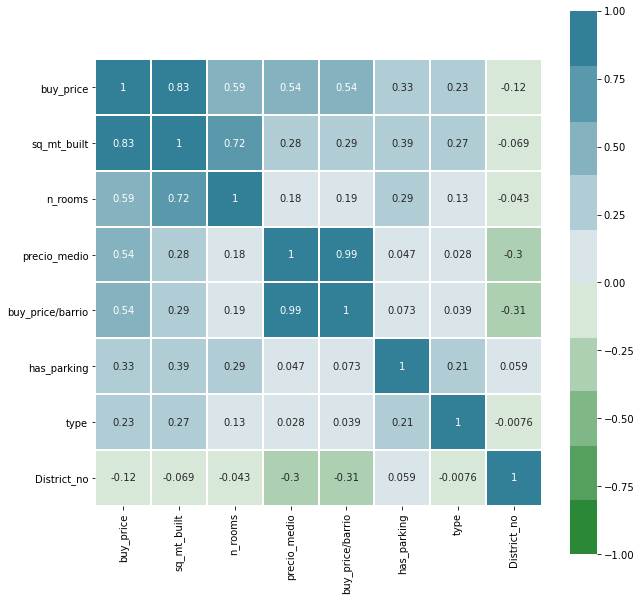

In [31]:
plt.figure(figsize=(10,10))

sns.heatmap(df_corr, 
            vmin = -1,
            vmax = 1,
            center = 0,
            cmap = sns.diverging_palette(130, 220, s = 85, l = 50, n = 10),
            square = True,
            annot = True,
            linewidths = 1);

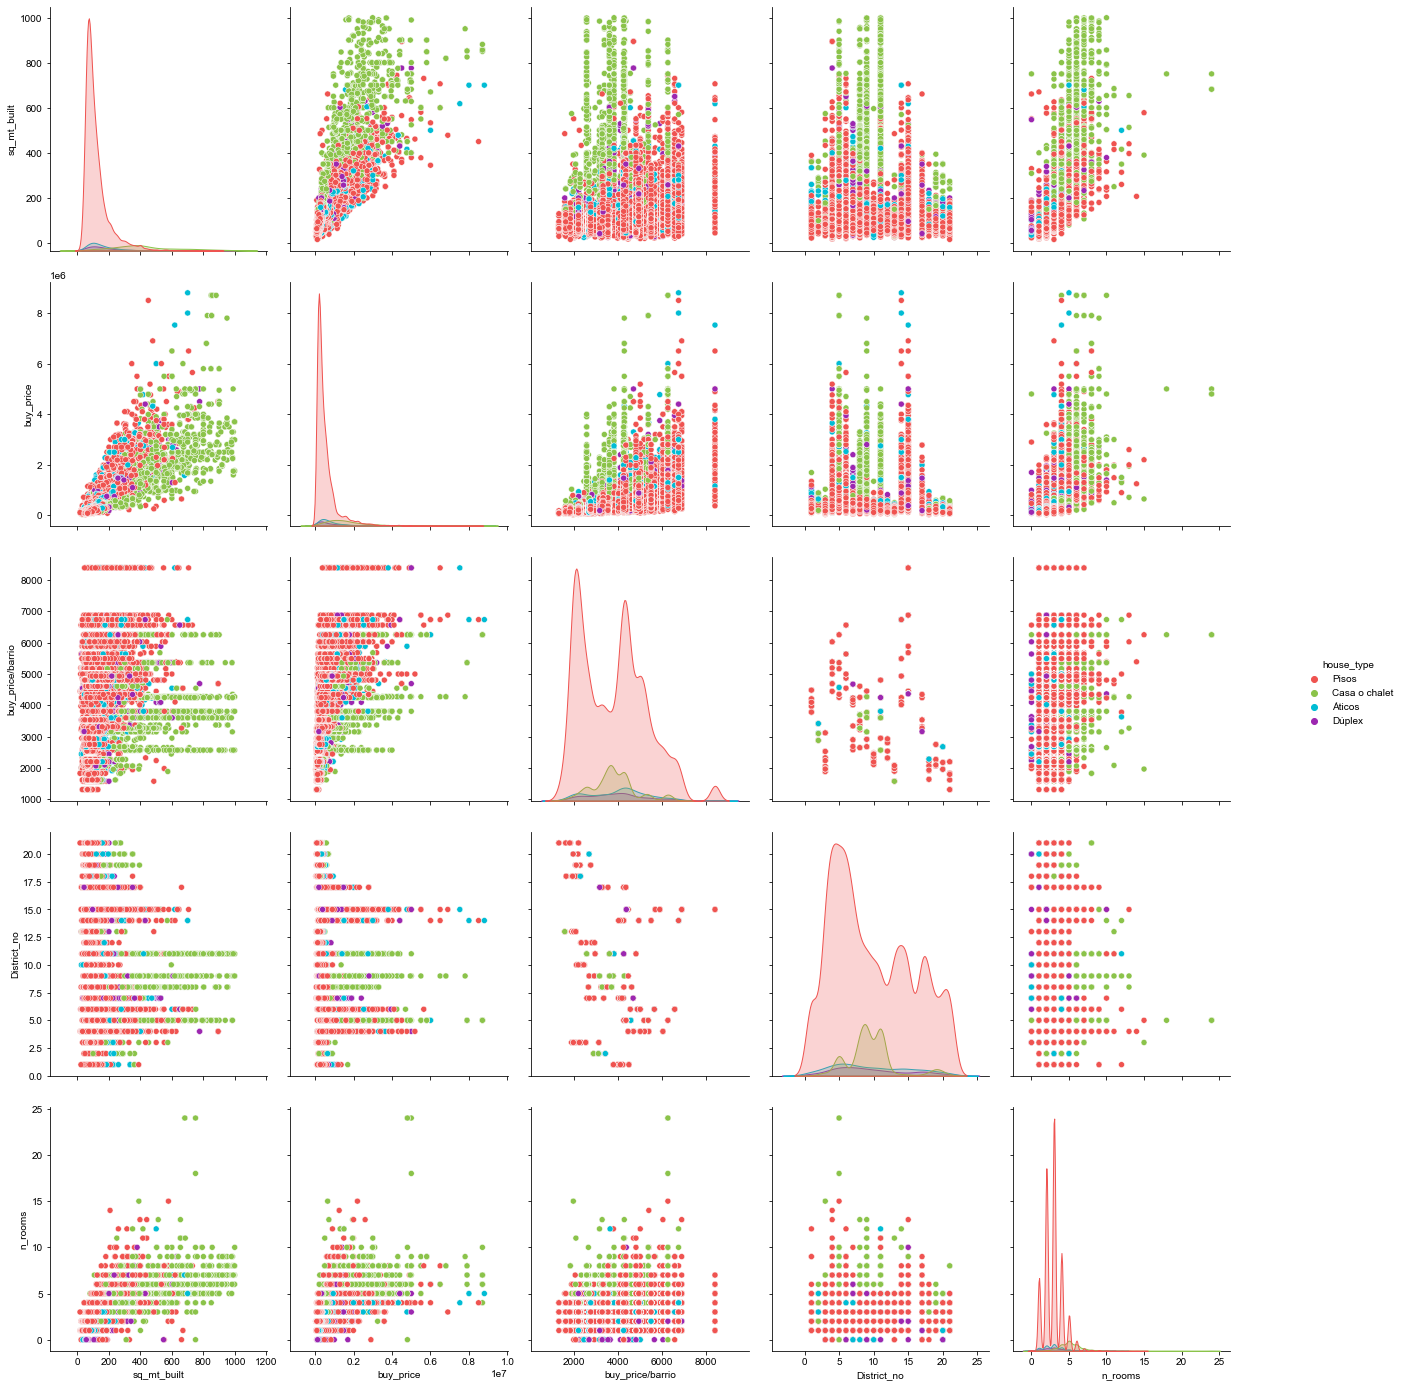

In [32]:
g = sns.pairplot(df[['sq_mt_built','buy_price','buy_price/barrio','District_no','n_rooms','house_type']], 
             hue = 'house_type',
            palette = ['#EF5350','#8BC34A','#00BCD4','#9C27B0'],
            corner = False)
g.fig.set_size_inches(20,20)
sns.set_style("whitegrid")

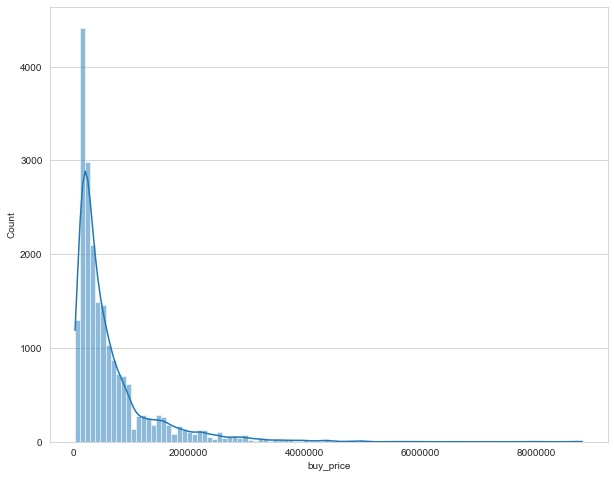

In [33]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(ax=ax, data=df['buy_price'], kde = True, bins = 100)
sns.set_style("whitegrid")
ax.ticklabel_format(style = 'plain')
ax.xaxis.grid()

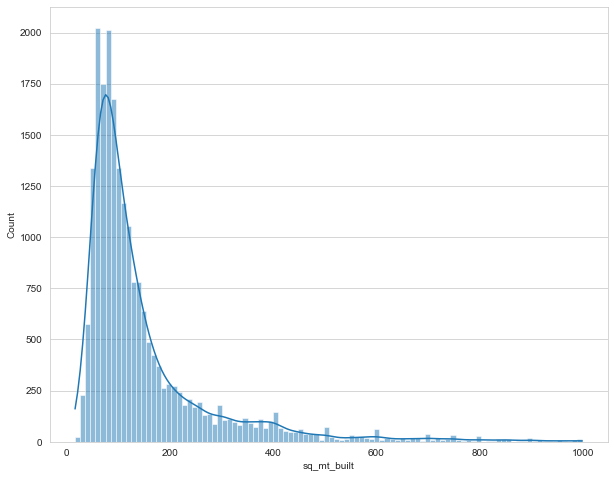

In [34]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(ax=ax, data=df['sq_mt_built'], kde = True, bins = 100)
sns.set_style("whitegrid")
ax.ticklabel_format(style = 'plain')
ax.xaxis.grid()

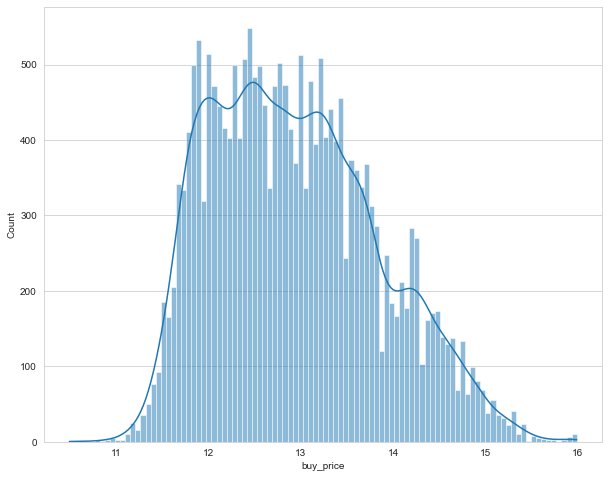

In [35]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(ax=ax, data=np.log(df['buy_price']), kde = True, bins = 100)
sns.set_style("whitegrid")
ax.ticklabel_format(style = 'plain')
ax.xaxis.grid()

In [36]:
fig = px.box(df, y=df['buy_price'], 
             height = 500, width = 550
            )
fig.update_yaxes(title="Precio de compra en €")
fig.update_layout(title_text="Boxplot target original", title_x=0.5)
fig.layout.font.family = 'Arial'
fig.update_layout(yaxis_tickformat = '.')
fig.show()

In [37]:
fig = px.box(df, y=np.log(df['buy_price']),
             height = 500, width = 550
            #title="Boxplot target log transformation"
            )
fig.update_yaxes(title="Precio de compra en €")
fig.update_layout(title_text="Boxplot target log transformation", title_x=0.5)
fig.layout.font.family = 'Arial'
fig.show()

In [38]:
mask = df['n_rooms'] > 23
df['n_rooms'][mask]

id
7169    24
7452    24
7518    24
Name: n_rooms, dtype: int64

In [39]:
df.loc[7169]

sq_mt_built                                                         750
n_rooms                                                              24
neighborhood_id       Neighborhood 28: El Viso (6255.45 €/m2) - Dist...
buy_price                                                       5000000
is_renewal_needed                                                  True
is_new_development                                                False
has_lift                                                          False
energy_certificate                                           en trámite
has_parking                                                        True
Barrio                                        Neighborhood 28: El Viso 
District                                                      Chamartín
District_no                                                           5
type                                                                  2
house_type                                                Casa o

In [40]:
#df_distritos = pd.read_excel('csv/Distritos.xlsx',index_col = 'Index')


In [41]:
df_barrios = pd.read_excel('Barrios_precios.xlsx', index_col=[0])
df_barrios['sq_mt_built'] = df_barrios['sq_mt_built'].astype(int)
df_barrios

FileNotFoundError: [Errno 2] No such file or directory: 'Barrios_precios.xlsx'

In [ ]:
from urllib.request import urlopen
#!pip install geojson
import json
import geojson
import pandas as pd
import plotly.express as px
with open('json/BARRIOS_orig.geojson') as f:
    madrid = geojson.load(f)

fig = px.choropleth_mapbox(df_barrios, 
                           geojson=madrid, 
                           locations="Barrio", 
                           featureidkey='properties.name',
                           color='buy_price/barrio',
                           zoom=10,
                           center=dict(lat=40.417,lon=-3.7),
                           #center={"lat": 45.5517, "lon": -73.7073}
                           opacity = 0.7,
                           color_continuous_scale='Blues',
                           #color_continuous_midpoint=0
                          )

mapbox_access_token = "pk.eyJ1Ijoia2Vyc3RpbmsiLCJhIjoiY2tnbGJ1enN6MGZ0ZTJ0cGNrbzJid3g4NSJ9.cN4FFIyy2xOcdjGHEUwzFQ"

fig.update_layout(
    mapbox=dict(accesstoken=mapbox_access_token))
fig.show()

In [ ]:
# df_prices = df[['District','buy_price']].groupby(df['District']).mean()
# df_prices['sqm_distrito'] = df['sq_mt_built'].groupby(df['District']).mean()
# df_prices['price/sqm'] = df_prices['buy_price']/df_prices['sqm_distrito']

In [ ]:
df[['Barrio_no','Barrio']] = df['Barrio'].str.split(': ', expand = True)

In [ ]:
caros = df['buy_price'] > 2000000
print('Precio medio > 2.000.000€:',int(df['buy_price'][mask].mean()),'€')
print('Precio medio total:', int(df['buy_price'].mean()),'€')

print(df['Barrio'][caros].value_counts().sum())
barrio_caro = df['Barrio'][caros]
barrio_caro_count = df['Barrio'][caros].value_counts()

In [ ]:
caros = df['buy_price'] > 2000000
df_caros = df[caros]
df_caros['Count'] = df_caros['Barrio']
df_caros = df_caros[['Barrio','District','Count']].groupby(['Barrio','District']).count()
df_caros = df_caros.reset_index()

In [ ]:
df_caros

In [ ]:
fig = px.bar(df_caros, x='Count', y='Barrio', color = 'District',  orientation='h', height = 700, width = 950)
#fig.update_xaxes(tickangle=-90)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.layout.font.family = 'Arial'
fig.show()

## Predicción

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from xgboost.sklearn import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle

from sklearn.linear_model import Lasso 
from scipy.stats import shapiro
from sklearn import metrics

In [ ]:
# X y para Dash (sin transformación)
# X = df[['n_rooms','sq_mt_built','buy_price/barrio','District_no','is_renewal_needed','has_parking','type']]
# y = df['buy_price']
#X.to_csv('data/X.csv', index = False)
#y.to_csv('data/y.csv', index = False)

In [ ]:
X = df[['sq_mt_log','n_rooms','is_new_development','has_lift','has_parking','type','District_no','precio_medio']]
y = df['buy_price_log']

In [ ]:
X, y = shuffle(X, y, random_state = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
rf = RandomForestRegressor(max_depth = 16, n_estimators = 150, min_samples_leaf = 2)
rf.fit(X_train, y_train)

In [ ]:
predictions_rf = np.exp(rf.predict(X_test))
print('MAE', mean_absolute_error(predictions_rf, np.exp(y_test)))

### Dummies

In [ ]:
X_dum = df[['sq_mt_log','n_rooms','is_new_development','has_lift','has_parking','house_type','District','precio_medio']]
y_dum = df['buy_price_log']
X_dum = pd.get_dummies(X_dum)
X_dum, y_dum = shuffle(X_dum, y_dum, random_state = 1)
X_dum_train, X_dum_test, y_dum_train, y_dum_test = train_test_split(X_dum, y_dum, test_size=0.2, random_state = 42)

In [ ]:
rf_dum = RandomForestRegressor(max_depth = 16, n_estimators = 150, n_jobs = -1)
rf_dum.fit(X_dum_train, y_dum_train)

In [ ]:
predictions_rf_dum = np.exp(rf_dum.predict(X_dum_test))
print('MAE', mean_absolute_error(predictions_rf_dum, np.exp(y_dum_test)))

In [ ]:
X_simple = df[['sq_mt_log']]
y_simple = df['buy_price_log']
X_simple, y_simple = shuffle(X_simple, y_simple, random_state = 1)
X_simple_train, X_simple_test, y_simple_train, y_simple_test = train_test_split(X_simple, y_simple, test_size=0.2, random_state = 42)

In [ ]:
rf_simple = RandomForestRegressor(max_depth = 16, n_estimators = 150, n_jobs = -1)
rf_simple.fit(X_simple_train, y_simple_train)

In [ ]:
predictions_rf_simple = np.exp(rf_simple.predict(X_simple_test))
print('MAE', mean_absolute_error(predictions_rf_simple, np.exp(y_simple_test)))

### Resultados

In [ ]:
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))
print(rf_dum.score(X_dum_train, y_dum_train))
print(rf_dum.score(X_dum_test, y_dum_test))
print('R^2 RF', r2_score(predictions_rf, np.exp(y_test)))
print('R^2 RF_dum', r2_score(predictions_rf_dum, np.exp(y_dum_test)))
print('MAE', mean_absolute_error(predictions_rf, np.exp(y_test)))
print('MAE', mean_absolute_error(predictions_rf_dum, np.exp(y_dum_test)))
print('MAPE', np.mean(np.abs((np.exp(y_test) - predictions_rf) / np.exp(y_test))) * 100)
print('MAPE', np.mean(np.abs((np.exp(y_dum_test) - predictions_rf_dum) / np.exp(y_dum_test))) * 100)

In [ ]:
error = 94374/(df['buy_price'].mean())
error

In [ ]:
# Crear df y_test
y_test_pred = np.exp(y_dum_test).reset_index()
y_test_pred.drop('id', axis = 1, inplace = True)
y_test_pred = y_test_pred.rename(columns = {'buy_price_log':'y_Test'})

In [ ]:
# Crear df predicciones
pred_series = pd.Series(predictions_rf_dum).reset_index()
pred_series.drop('index', axis = 1, inplace = True)
pred_series = pred_series.rename(columns = {0:'Prediction'})

In [ ]:
# Crear df para plotear predicciones vs y-test
df_preds = pred_series.merge(y_test_pred, on = pred_series.index)
df_preds = df_preds.drop('key_0', axis = 1)

In [ ]:
df_preds['Prediction'] = df_preds['Prediction'].astype(int)
df_preds['y_Test'] = df_preds['y_Test'].astype(int)
df_preds

In [ ]:
fig = px.scatter(x=df_preds['y_Test'], y=df_preds['Prediction'], trendline="ols", trendline_color_override="red")
fig.update_xaxes(title="Precio de compra en € Target")
fig.update_yaxes(title="Precio de compra en € - Predicción")
fig.layout.template = 'plotly_dark'
fig.update_layout(yaxis_tickformat = '€')
fig.update_layout(xaxis_tickformat = '€')
fig.show()

In [ ]:
fig = px.scatter(x=df['sq_mt_built'], y=df['buy_price'], trendline="ols", trendline_color_override="red")
fig.update_xaxes(title="m2 construidos")
fig.update_yaxes(title="Precio de compra en € - Predicción")
fig.layout.template = 'plotly_dark'
fig.update_layout(yaxis_tickformat = '€')
fig.update_layout(xaxis_tickformat = '€')
fig.show()

## Feature Importance

In [ ]:
X_feat = df[['sq_mt_built','buy_price/barrio','n_rooms','has_lift','District_no','has_parking','type','is_renewal_needed','is_new_development']]
y_feat = df['buy_price']
names = X_train.columns
X_feat, y_feat = shuffle(X_feat, y_feat, random_state = 42)

In [ ]:
rf_feat = RandomForestRegressor(max_depth = 14, n_estimators = 150)
rf_feat.fit(X_train, y_train)

In [ ]:
scores = sorted(zip(map(lambda x: round(x, 4), rf_feat.feature_importances_*100), names), reverse = True)

In [ ]:
sel = SelectKBest(score_func = f_regression, k=5)
X_new = sel.fit_transform(X_train, y_train)

In [ ]:
best_feat = pd.DataFrame({'feature': names, 'FI Rforest': rf.feature_importances_*100, 'score KBest': sel.scores_})
best_feat = best_feat.sort_values('FI Rforest', ascending=False)


In [ ]:
tot_KBest = best_feat['score KBest'].sum()
best_feat['KBest 100%'] = best_feat['score KBest']/tot_KBest*100
best_feat

In [ ]:
best_feat_melt = best_feat.melt(id_vars='feature', value_vars = ['FI Rforest','KBest 100%'],var_name = 'Modelo',value_name="Values")
best_feat_melt

In [ ]:
fig = px.bar(best_feat_melt, x='Modelo', y="Values", color="feature", title="Feature Importance/KBest")
fig.layout.template = 'plotly_dark'
fig.show()

## GridSearch

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVR

# Si solo es el modelo, no hará falta meterlo en un pipeline

rand_forest = RandomForestRegressor()

xgbr = XGBRegressor()

svm = SVR()


lin_reg = LinearRegression()

lasso = Lasso()



'''
Para iterar hiperparámetros de varios elementos del pipeline, le ponemos un nombre
a cada elemento en el pipeline, por ejemplo 'selectkbest' y 'svm', para luego en el
grid de hiperparametros identificar sus respectivos parametros mediante el nombre
que le hayamos puesto en el pipeline, dos guines bajos y el nombre del hiperparámetro.
'''

xgbr_param = {'booster' : ['gblinear','dart'],
             'validate_parameters' : [True],
             'alpha': [0.000001,0.00001,0.0001,0.1],
             'lambda': [0.000001,0.00001,0.0001,0.1]}


grid_random_forest = {"n_estimators": [150],
                     "max_depth": [14,16]}

lin_reg_param = {'copy_X': [True, False],'fit_intercept': [True, False], 'normalize':[True,False] 
                }

lasso_param = {'alpha' : [0.000001,0.00001,0.0001,0.1]}

svm_param = {'C' : [2000,2500]}

In [ ]:
models = [
    ('rand_forest', rand_forest, grid_random_forest),
    ('xgbr',xgbr,xgbr_param),
    ('svm', svm, svm_param),
    ('lin_reg', lin_reg, lin_reg_param),
    ('lasso', lasso, lasso_param)
]
# Declaro en un diccionario los pipelines e hiperparametros
models_gridsearch = {}
for i in models:
    models_gridsearch[i[0]] = GridSearchCV(i[1],
                                           i[2],
                                           cv=10,
                                           scoring="neg_mean_absolute_error",
                                           verbose=1,
                                           n_jobs=-1)
    models_gridsearch[i[0]].fit(X_dum_train, y_dum_train)
    
best_grids = [(i, j.best_score_) for i, j in models_gridsearch.items()]

best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
best_grids

In [ ]:
print(models_gridsearch['xgbr'].best_estimator_)
print(models_gridsearch['lasso'].best_estimator_)
print(models_gridsearch['lin_reg'].best_estimator_)
print(models_gridsearch['rand_forest'].best_estimator_)
print(models_gridsearch['svm'].best_estimator_)

In [ ]:
metrics.SCORERS.keys()

## Learning Curve

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [ ]:
#X_dum = pd.get_dummies(X_dum)
#X_dum, y_dum = shuffle(X_dum, y_dum, random_state = 42)
X_lc = np.array(X_dum)
y_lc = np.array(y_dum)

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
       
    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid(axis = 'x')
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="#EF5350",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="#8BC34A",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid(axis = 'x')
    axes[1].plot(train_sizes, fit_times_mean, 'o-', color = '#26A69A')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.3)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid(axis = 'x')
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-', color = '#B2EBF2')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, color = '#B2EBF2', alpha=0.3)
    axes[2].set_ylim(0.93,0.96)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    
    plt.style.use("dark_background")
    
    return plt

fig, axes = plt.subplots(3, 3, figsize=(17, 15), dpi = 150)

X = X_lc
y = y_lc

title = r"RandomForestRegressor(max_depth=16)"
cv = 5
estimator = RandomForestRegressor(max_depth=16, n_estimators=150)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01), 
                    cv=cv, n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5))

title = r"RandomForestRegressor(max_depth=10)"
cv = 5
estimator = RandomForestRegressor(max_depth=10, n_estimators=150)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01), 
                    cv=cv, n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5))

title = r"RandomForestRegressor(max_depth=7)"
cv = 5
estimator = RandomForestRegressor(max_depth=7, n_estimators=150)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 2], ylim=(0.7, 1.01), 
                    cv=cv, n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5))


plt.show()